# 02_Gradient-Based

In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16()
model.summary()

2022-04-28 17:12:51.429940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-04-28 17:12:51.430685: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-04-28 17:12:51.430911: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with th

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
def load_imagenet_labels(labels_file):
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

imagenet_labels = load_imagenet_labels('data/ImageNetLabels.txt')

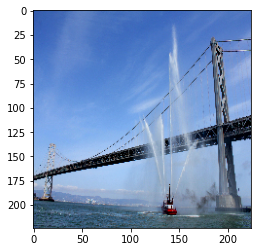

In [5]:
def read_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(224, 224))
#     image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

image = read_image('data/fireboat.jpg')
plt.imshow(image/255)

In [6]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    inputs = preprocess_input(image_batch)
    predictions = model(inputs)
    top_probs, top_idxs = tf.math.top_k(input=predictions, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

In [7]:
pred_label, pred_prob = top_k_predictions(image)
for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

fireboat: 98.6%
drilling platform: 0.3%
crane: 0.2%


## [1. Sensitivity Analysis (Simonyan et al. 14)](https://arxiv.org/abs/1312.6034)

In [8]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

In [9]:
image_batch = tf.expand_dims(image, 0)
inputs = preprocess_input(image_batch)
gradients = compute_gradients(
    images=inputs,
    target_class_idx=554)

attribution_mask = tf.reduce_sum(tf.math.abs(tf.squeeze(gradients)), axis=-1)

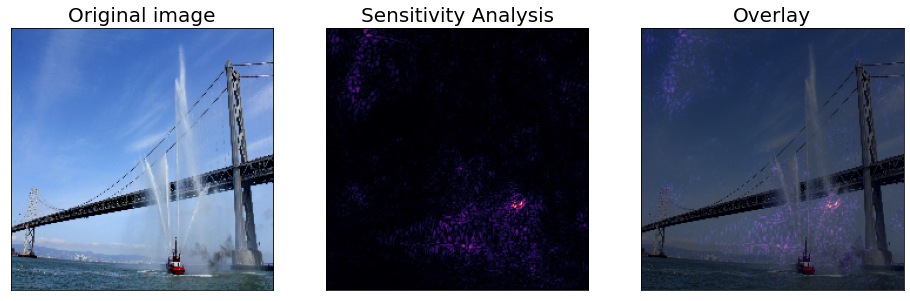

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity Analysis', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

## [2. SmoothGrad (Smikov et al. 17)](https://arxiv.org/abs/1706.03825)

In [18]:
def generate_noisy_images(images, num_samples, noise):
    repeated_images = tf.repeat(images, num_samples, axis=0)
    noise = np.random.normal(0, noise, repeated_images.shape).astype(np.float32)
    return tf.clip_by_value(repeated_images + noise, 0, 255)

In [46]:
num_samples = 10
noise = 10
image_batch = tf.expand_dims(image, 0)
noisy_images = generate_noisy_images(image_batch, num_samples, noise)

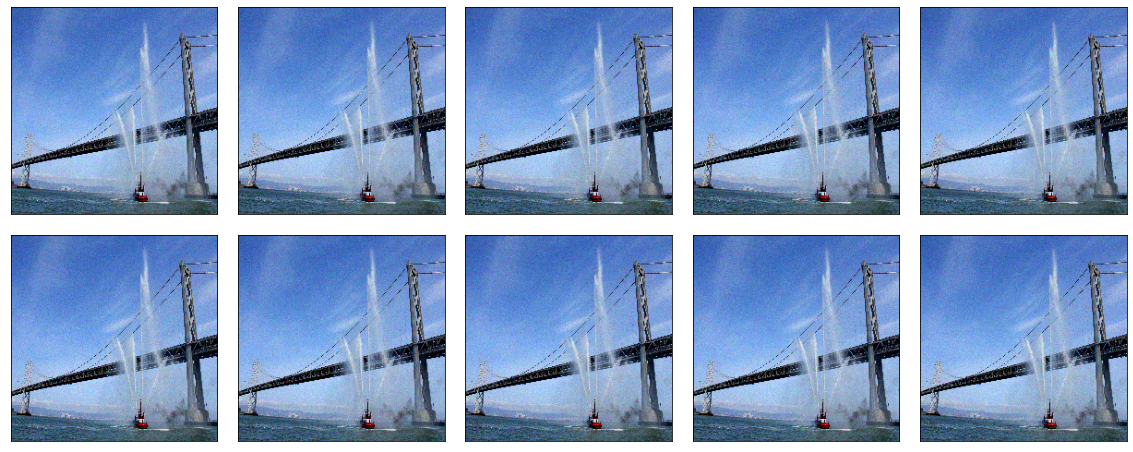

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(5):
    ax[0, i].imshow(noisy_images[i]/255)
    ax[1, i].imshow(noisy_images[i+5]/255)

In [48]:
inputs = preprocess_input(noisy_images)
gradients = compute_gradients(
    images=inputs,
    target_class_idx=554)

averaged_grads = tf.reduce_mean(gradients, axis=0)
attribution_mask = tf.reduce_sum(tf.math.abs(averaged_grads), axis=-1)

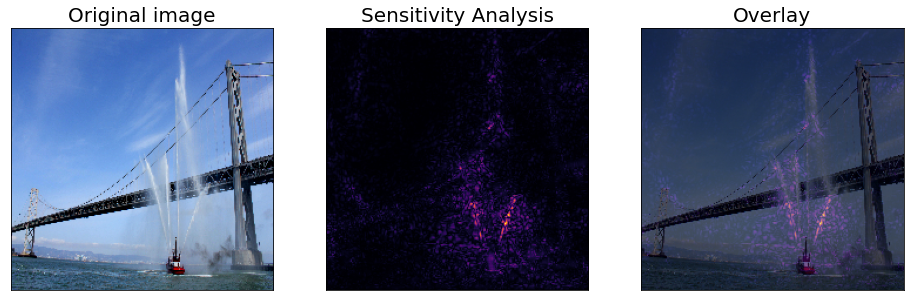

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity Analysis', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

In [50]:
def smoothgrad(image, num_samples, noise=1):
    image_batch = tf.expand_dims(image, 0)
    noisy_images = generate_noisy_images(image_batch, num_samples, noise)
    inputs = preprocess_input(noisy_images)

    gradients = compute_gradients(
        images=inputs,
        target_class_idx=554)

    averaged_grads = tf.reduce_mean(gradients, axis=0)
    attribution_mask = tf.reduce_sum(tf.math.abs(averaged_grads), axis=-1)
    return attribution_mask

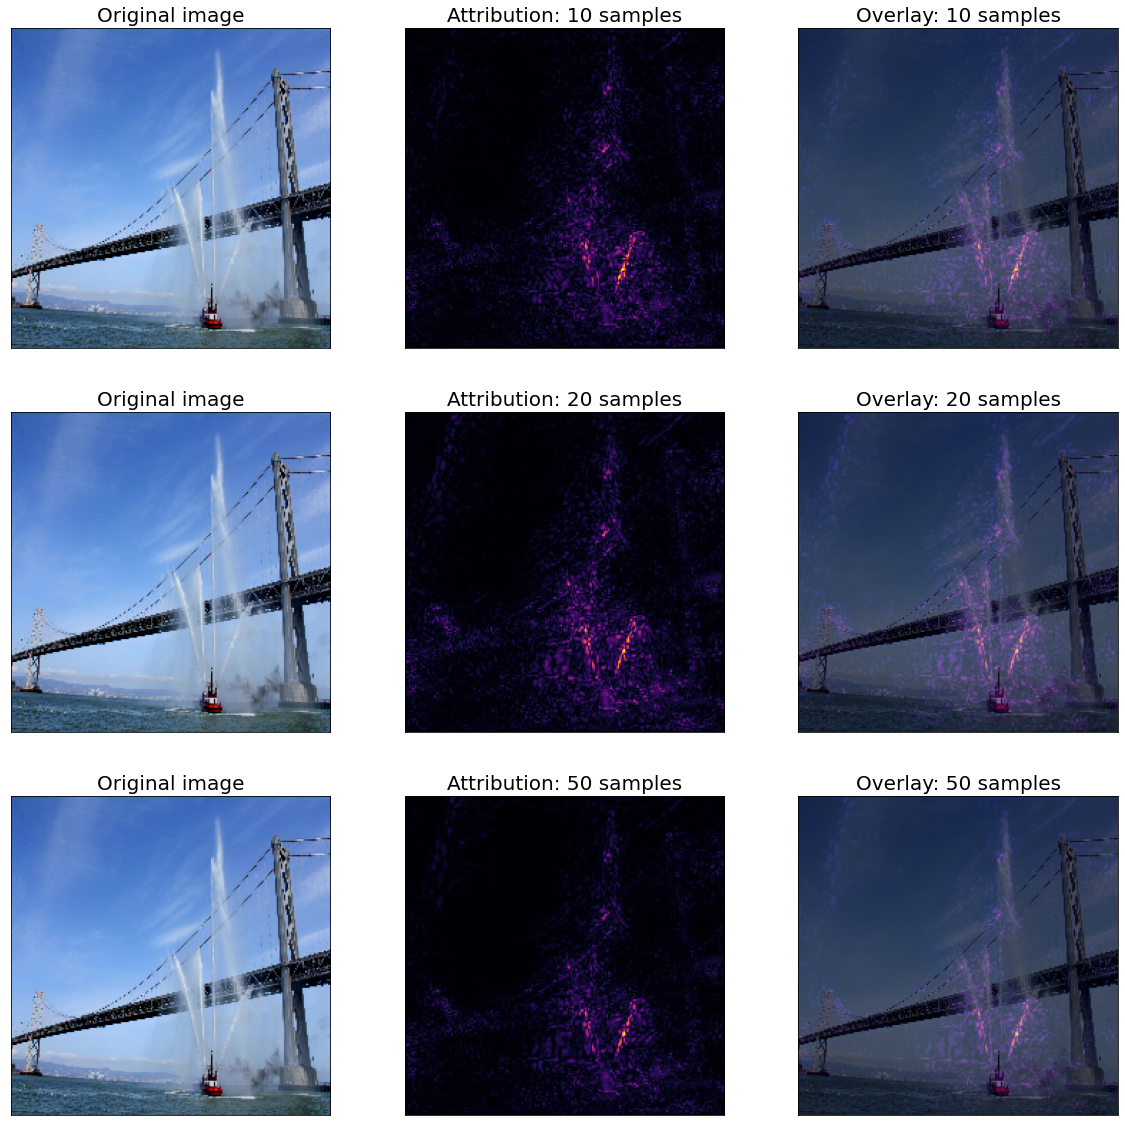

In [51]:
num_samples = [10, 20, 50] 

fig, axs = plt.subplots(nrows=3, ncols=3, squeeze=False, figsize=(20, 20),
                        subplot_kw={'xticks':[], 'yticks':[]})

for i, num_sample in enumerate(num_samples):
    
    axs[i, 0].set_title('Original image', fontsize=20)
    axs[i, 0].imshow(image/255)
    
    attribution_mask = smoothgrad(image, num_sample, noise=10)
    
    axs[i, 1].set_title(f'Attribution: {num_sample} samples', fontsize=20)
    axs[i, 1].imshow(attribution_mask, cmap=cm.inferno)

    axs[i, 2].set_title(f'Overlay: {num_sample} samples', fontsize=20)
    axs[i, 2].imshow(attribution_mask, cmap=cm.inferno)
    axs[i, 2].imshow(image/255, alpha=0.4)

## [3. Integrated Gradients (Sundararajan et al. 17)](https://arxiv.org/abs/1703.01365)

## Calculate Integrated Gradients

Your model, Inception V1, is a learned function that describes a mapping between your input feature space, image pixel values, and an output space defined by ImageNet class probability values between 0 and 1. Early interpretability methods for neural networks assigned feature importance scores using gradients, which tell you which pixels have the steepest local relative to your model's prediction at a given point along your model's prediction function. However, gradients only describe *local* changes in your model's prediction function with respect to pixel values and do not fully describe your entire model prediction function. As your model fully "learns" the relationship between the range of an individual pixel and the correct ImageNet class, the gradient for this pixel will *saturate*, meaning become increasingly small and even go to zero. Consider the simple model function below:

In [52]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

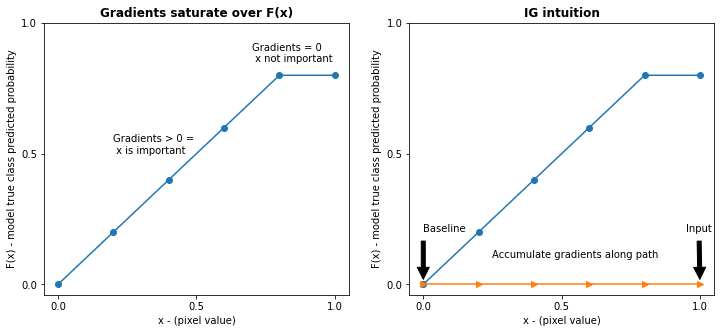

In [53]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();

* **left**: Your model's gradients for pixel `x` are positive between 0.0 and 0.8 but go to 0.0 between 0.8 and 1.0. Pixel `x` clearly has a significant impact on pushing your model toward 80% predicted probability on the true class. *Does it make sense that pixel `x`'s importance is small or discontinuous?*

* **right**: The intuition behind IG is to accumulate pixel `x`'s local gradients and attribute its importance as a score for how much it adds or subtracts to your model's overall output class probability. You can break down and compute IG in 3 parts: 
  1. interpolate small steps along a straight line in the feature space between 0 (a baseline or starting point) and 1 (input pixel's value) 
  2. compute gradients at each step between your model's predictions with respect to each step 
  3. approximate the integral between your baseline and input by accumulating (cumulative average) these local gradients.

To reinforce this intuition, you will walk through these 3 parts by applying IG to the example "Fireboat" image below. 

### Establish a baseline

A baseline is an input image used as a starting point for calculating feature importance. Intuitively, you can think of the baseline's explanatory role as representing the impact of the absence of each pixel on the "Fireboat" prediction to contrast with its impact of each pixel on the "Fireboat" prediction when present in the input image. As a result, the choice of the baseline plays a central role in interpreting and visualizing pixel feature importances. For additional discussion of baseline selection, see the resources in the "Next steps" section at the bottom of this tutorial. Here, you will use a black image whose pixel values are all zero.

Other choices you could experiment with include an all white image, or a random image, which you can create with `tf.random.uniform(shape=(224,224,3), minval=0.0, maxval=1.0)`.

In [54]:
baseline = tf.zeros(shape=(224,224,3))

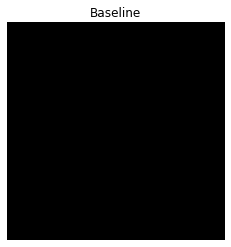

In [55]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

### Unpack formulas into code

The formula for Integrated Gradients is as follows:

$IntegratedGradients_{i}(x) ::= (x_{i} - x'_{i})\times\int_{\alpha=0}^1\frac{\partial F(x'+\alpha \times (x - x'))}{\partial x_i}{d\alpha}$

where:

$_{i}$ = feature   
$x$ = input  
$x'$ = baseline   
$\alpha$ = interpolation constant to perturb features by

In practice, computing a definite integral is not always numerically possible and can be computationally costly, so you compute the following numerical approximation:

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\partial F(x' + \frac{k}{m}\times(x - x'))}{\partial x_{i}} \times \frac{1}{m}$

where:

$_{i}$ = feature (individual pixel)  
$x$ = input (image tensor)  
$x'$ = baseline (image tensor)  
$k$ = scaled feature perturbation constant  
$m$ = number of steps in the Riemann sum approximation of the integral  
$(x_{i}-x'_{i})$ = a term for the difference from the baseline. This is necessary to scale the integrated gradients and keep them in terms of the original image. The path from the baseline image to the input is in pixel space. Since with IG you are integrating in a straight line (linear transformation) this ends up being roughly equivalent to the integral term of the derivative of the interpolated image function with respect to $\alpha$ with enough steps. The integral sums each pixel's gradient times the change in the pixel along the path. It's simpler to implement this integration as uniform steps from one image to the other, substituting $x := (x' + \alpha(x-x'))$. So the change of variables gives $dx = (x-x')d\alpha$. The $(x-x')$ term is constant and is factored out of the integral.

### Interpolate images

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\partial F(\overbrace{x' + \frac{k}{m}\times(x - x')}^\text{interpolate m images at k intervals})}{\partial x_{i}} \times \frac{1}{m}$

First, you will generate a [linear interpolation](https://en.wikipedia.org/wiki/Linear_interpolation) between the baseline and the original image. You can think of interpolated images as small steps in the feature space between your baseline and input, represented by $\alpha$ in the original equation.

In [56]:
m_steps = 50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [57]:
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

Let's use the above function to generate interpolated images along a linear path at alpha intervals between a black baseline image and the example "Fireboat" image.

In [58]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=image,
    alphas=alphas)

Let's visualize the interpolated images. Note: another way of thinking about the $\alpha$ constant is that it is consistently increasing each interpolated image's intensity.

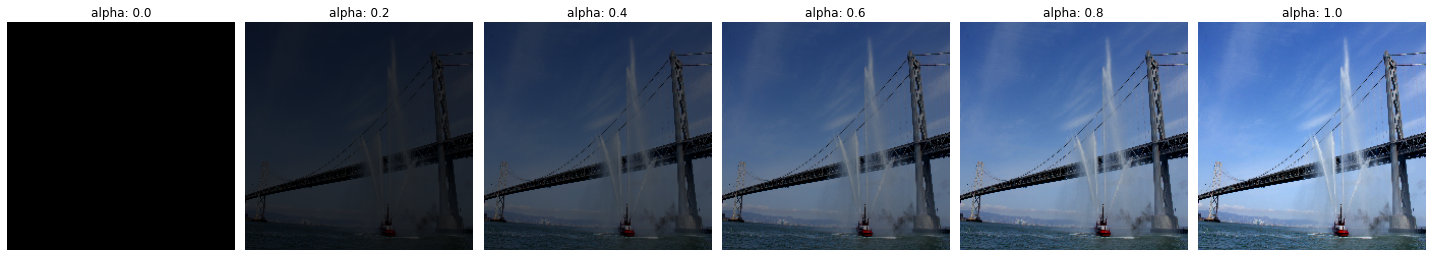

In [60]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image/255)
    plt.axis('off')

plt.tight_layout();

### Compute gradients

Now let's take a look at how to calculate gradients in order to measure the relationship between changes to a feature and changes in the model's predictions. In the case of images, the gradient tells us which pixels have the strongest effect on the models predicted class probabilities.

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\overbrace{\partial F(\text{interpolated images})}^\text{compute gradients}}{\partial x_{i}} \times \frac{1}{m}$

where:  
$F()$ = your model's prediction function  
$\frac{\partial{F}}{\partial{x_i}}$ = gradient (vector of partial derivatives $\partial$) of your model F's prediction function relative to each feature $x_i$

TensorFlow makes computing gradients easy for you with a [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape).

Let's compute the gradients for each image along the interpolation path with respect to the correct output. Recall that your model returns a `(1, 1001)` shaped `Tensor` with logits that you convert to predicted probabilities for each class. You need to pass the correct ImageNet target class index to the `compute_gradients` function for your image.

In [61]:
inputs = preprocess_input(interpolated_images)

path_gradients = compute_gradients(
    images=inputs,
    target_class_idx=554)

Note the output shape of `(n_interpolated_images, img_height, img_width, RGB)`, which gives us the gradient for every pixel of every image along the interpolation path. You can think of these gradients as measuring the change in your model's predictions for each small step in the feature space.

In [62]:
print(path_gradients.shape)

(51, 224, 224, 3)


**Visualizing gradient saturation**

Recall that the gradients you just calculated above describe *local* changes to your model's predicted probability of "Fireboat" and can *saturate*.

These concepts are visualized using the gradients you calculated above in the 2 plots below.

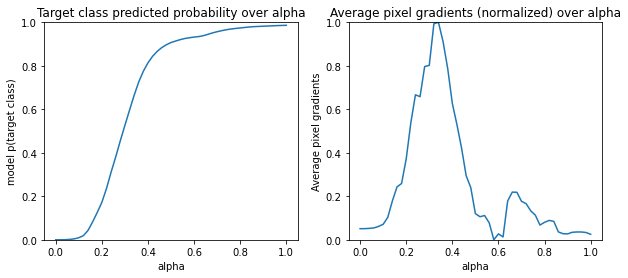

In [65]:
inputs = preprocess_input(interpolated_images)
pred_proba = model(inputs)[:, 554]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

* **left**: This plot shows how your model's confidence in the "Fireboat" class varies across alphas. Notice how the gradients, or slope of the line, largely flattens or saturates between 0.6 and 1.0 before settling at the final "Fireboat" predicted probability of about 40%.

* **right**: The right plot shows the average gradients magnitudes over alpha more directly. Note how the values sharply approach and even briefly dip below zero. In fact, your model "learns" the most from gradients at lower values of alpha before saturating. Intuitively, you can think of this as your model has learned the pixels e.g. water cannons to make the correct prediction, sending these pixels gradients to zero, but is still quite uncertain and focused on spurious bridge or water jet pixels as the alpha values approach the original input image.

To make sure these important water cannon pixels are reflected as important to the "Fireboat" prediction, you will continue on below to learn how to accumulate these gradients to accurately approximate how each pixel impacts your "Fireboat" predicted probability.


### Accumulate gradients (integral approximation)

There are many different ways you can go about computing the numerical approximation of an integral for IG with different tradeoffs in accuracy and convergence across varying functions. A popular class of methods is called [Riemann sums](https://en.wikipedia.org/wiki/Riemann_sum). Here, you will use the Trapezoidal rule (you can find additional code to explore different approximation methods at the end of this tutorial).

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times \overbrace{\sum_{k=1}^{m}}^\text{Sum m local gradients}
\text{gradients(interpolated images)} \times \overbrace{\frac{1}{m}}^\text{Divide by m steps}$

From the equation, you can see you are summing over `m` gradients and dividing by `m` steps. You can implement the two operations together for part 3 as an *average of the local gradients of `m` interpolated predictions and input images*.

In [66]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

The `integral_approximation` function takes the gradients of the predicted probability of the target class with respect to the interpolated images between the baseline and the original image.

In [67]:
ig = integral_approximation(
    gradients=path_gradients)

You can confirm averaging across the gradients of `m` interpolated images returns an integrated gradients tensor with the same shape as the original "Giant Panda" image.

In [68]:
print(ig.shape)

(224, 224, 3)


### Putting it all together

Now you will combine the 3 previous general parts together into an `IntegratedGradients` function and utilize a [@tf.function](https://www.tensorflow.org/guide/function) decorator to compile it into a high performance callable TensorFlow graph. This is implemented as 5 smaller steps below:


$IntegratedGrads^{approx}_{i}(x)::=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$

1. Generate alphas $\alpha$

2. Generate interpolated images = $(x' + \frac{k}{m}\times(x - x'))$

3. Compute gradients between model $F$ output predictions with respect to input features = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$

4. Integral approximation through averaging gradients = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. Scale integrated gradients with respect to original image = $(x_{i}-x'_{i}) \times \text{integrated gradients}$. The reason this step is necessary is to make sure that the attribution values accumulated across multiple interpolated images are in the same units and faithfully represent the pixel importances on the original image.

In [70]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Initialize TensorArray outside loop to collect gradients.    
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    
    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        # 2. Generate interpolated inputs between baseline and input.
        interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                           image=image,
                                                           alphas=alpha_batch)

        # 3. Compute gradients between model outputs and interpolated inputs.
        inputs = preprocess_input(interpolated_path_input_batch)
        gradient_batch = compute_gradients(images=inputs,
                                           target_class_idx=target_class_idx)
        
        # Write batch indices and gradients to extend TensorArray.
        gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
  
    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()

    # 4. Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # 5. Scale integrated gradients with respect to input. 
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

In [71]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=image,
                                       target_class_idx=554,
                                       m_steps=240)

attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)

Again, you can check that the IG feature attributions have the same shape as the input "Fireboat" image.

In [72]:
print(attribution_mask.shape)

(224, 224)


The paper suggests the number of steps to range between 20 to 300 depending upon the example (although in practice this can be higher in the 1,000s to accurately approximate the integral). You can find additional code to check for the appropriate number of steps in the "Next steps" resources at the end of this tutorial.

### Visualize attributions

You are ready to visualize attributions, and overlay them on the original image. The code below sums the absolute values of the integrated gradients across the color channels to produce an attribution mask. This plotting method captures the relative impact of pixels on the model's predictions. 

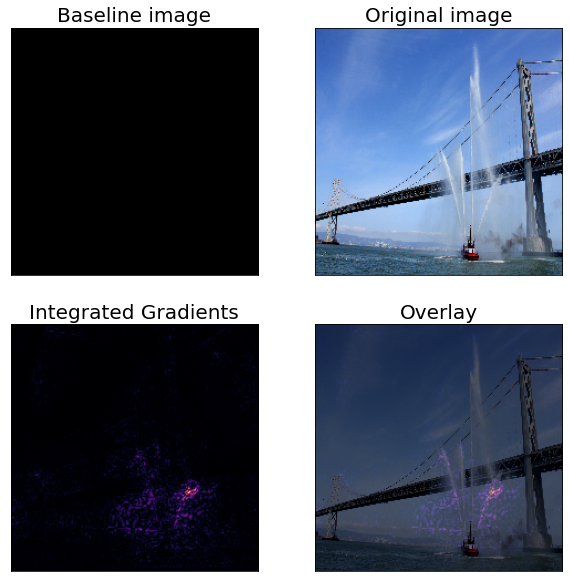

In [73]:
fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(10, 10),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Baseline image', fontsize=20)
axs[0, 0].imshow(baseline)

axs[0, 1].set_title('Original image', fontsize=20)
axs[0, 1].imshow(image/255)

axs[1, 0].set_title('Integrated Gradients', fontsize=20)
axs[1, 0].imshow(attribution_mask, cmap=cm.inferno)

axs[1, 1].set_title('Overlay', fontsize=20)
axs[1, 1].imshow(attribution_mask, cmap=cm.inferno)
axs[1, 1].imshow(image/255, alpha=0.4)

## 練習時間：
### 自己更改 patch_size 練習看看